In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import math
import sympy as sp
from tqdm import tqdm
import seaborn as sns


%matplotlib inline
seed = 42

np.random.seed(42)


# Part 1 - MLP for Regression (Spotify Song Popularity)

In this part, we will build a **4-layer** MLP to predict song popularity.

## 1.1 Data Loading and Preprocessing

This section prepares the dataset for a regression task on Spotify song popularity.

It includes feature selection, data cleaning, normalization, and train–test splitting,formatted to match the expected input structure of a fully connected neural network.


In [6]:
# Load the dataset
try:
    spotify_df = pd.read_csv('tracks.csv')
    
    # The tracks.csv has 'release_date', so we create 'year' from it
    if 'year' not in spotify_df.columns and 'release_date' in spotify_df.columns:
        spotify_df['year'] = pd.to_datetime(spotify_df['release_date'], errors='coerce').dt.year

except FileNotFoundError:
    print("Dataset file 'tracks.csv' not found.")
    print("Falling back to a synthetic dataset for pipeline validation.")
    spotify_df = pd.DataFrame(np.random.rand(100, 14), 
                              columns=['acousticness', 'danceability', 'energy', 'instrumentalness', 
                                       'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity', 
                                       'key', 'mode', 'explicit', 'year'])

# Select features (X) and target (Y)
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
            'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 
            'key', 'mode', 'explicit', 'year']
target = 'popularity'

# Drop NAs
spotify_df = spotify_df.dropna(subset=features + [target])

# Ensure numeric types
for col in features + [target]:
    spotify_df[col] = pd.to_numeric(spotify_df[col], errors='coerce')
    
spotify_df = spotify_df.dropna()

# For performance, we'll sample 30,000 tracks
if len(spotify_df) > 30000:
    spotify_df = spotify_df.sample(n=30000, random_state=seed)

X_spotify = spotify_df[features]
Y_spotify = spotify_df[[target]]

# Scale the data
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X_spotify_scaled = scaler_X.fit_transform(X_spotify)
Y_spotify_scaled = scaler_Y.fit_transform(Y_spotify)

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_spotify_scaled, Y_spotify_scaled, test_size=0.2, random_state=seed)

# Transpose for our NN architecture: (features, num_examples)
x_train_reg = X_train_reg.T
y_train_reg = y_train_reg.T
x_test_reg = X_test_reg.T
y_test_reg = y_test_reg.T

print(f"X_train_reg shape: {x_train_reg.shape}")
print(f"y_train_reg shape: {y_train_reg.shape}")
print(f"(Input features, 'I' = {x_train_reg.shape[0]})")

X_train_reg shape: (13, 24000)
y_train_reg shape: (1, 24000)
(Input features, 'I' = 13)


## 1.2 MLP Architecture

**Architecture:** `input - FC - ReLU - FC - ReLU - FC - ReLU - FC - Output`

The output activation is also ReLU (for Regression) to ensure our prediction `popularity` is non-negative.

**Dimensions (Example):**
* `I`: Input features (13 for Spotify)
* `H1`: 64 neurons
* `H2`: 32 neurons
* `H3`: 16 neurons
* `O`: Output Layer (1 for this regression task)

### 1.3 Helper: Parameter Initialization (He Initialization)

To ensure the network learns effectively using ReLU activations, we must initialize weights carefully. If weights are too small, gradients vanish. If too large, they explode.


In [7]:
def Initialization(I, H1, H2, H3, O):
    '''
    Initializes weights using He Initialization (optimized for ReLU).
    
    Inputs:
        I, H1, H2, H3, O: Number of neurons in each layer.
        
    Returns:
        List of parameters: [W1, b1, W2, b2, W3, b3, W4, b4]
    '''
    np.random.seed(42) # Ensure reproducibility

    # Calculate scaling factors for He Initialization
    scale1 = np.sqrt(2.0 / I)
    scale2 = np.sqrt(2.0 / H1)
    scale3 = np.sqrt(2.0 / H2)
    scale4 = np.sqrt(2.0 / H3)
    
    # Layer 1: Input -> Hidden 1
    W1 = np.random.randn(H1, I) * scale1
    b1 = np.zeros((H1, 1)) 
    
    # Layer 2: Hidden 1 -> Hidden 2
    W2 = np.random.randn(H2, H1) * scale2
    b2 = np.zeros((H2, 1))
    
    # Layer 3: Hidden 2 -> Hidden 3
    W3 = np.random.randn(H3, H2) * scale3
    b3 = np.zeros((H3, 1))
    
    # Layer 4: Hidden 3 -> Output
    W4 = np.random.randn(O, H3) * scale4
    b4 = np.zeros((O, 1))
    
    print("Parameters initialized with He Initialization.")
    return [W1, b1, W2, b2, W3, b3, W4, b4]

In [8]:
#Sample test case
np.random.seed(seed)
params_list = Initialization(13, 64, 32, 16, 1)
assert len(params_list) == 8
assert params_list[0].shape == (64, 13) 
assert params_list[1].shape == (64, 1)  
assert params_list[6].shape == (1, 16)  
assert np.mean(params_list[0]) < 0.1 and np.mean(params_list[0]) > -0.1
print('Sample Test passed', '\U0001F44D')

Parameters initialized with He Initialization.
Sample Test passed 👍


## 1.4 Activation Function (ReLU)


In [9]:
# x: activation input of shape (n_units, m)
def relu(x):
    # Element-wise ReLU activation
    return np.maximum(x, 0)

def drelu(x):
    # Boolean mask for element-wise derivative of ReLU
    return (x > 0).astype(int)

In [10]:
# sample test case
x_sample = np.array([[3, -4], [0, -0.5]])   #two samples with the values of its two fetchers.
assert np.allclose(relu(x_sample), np.array([[3, 0], [0, 0]]))
assert np.allclose(drelu(x_sample), np.array([[1, 0], [0, 0]]))
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


## 1.5 Forward Propagation


In [11]:
import numpy as np


def feed_forward(X, params):
    '''
    Inputs:
    - X : Input data of shape (I, num_examples)
    - params: List of parameters [W1, b1, W2, b2, W3, b3, W4, b4]

    Outputs:
    - y_out : predicted output (A4), shape (O, num_examples)
    - cache : List containing [Z1, A1, Z2, A2, Z3, A3, Z4, A4]
    '''
    W1, b1, W2, b2, W3, b3, W4, b4 = params
    cache = []
    A0 = X
    Z1 = W1 @ A0 + b1
    A1 = relu(Z1)
    Z2 = W2 @ A1 + b2
    A2 = relu(Z2)
    Z3 = W3 @ A2 + b3
    A3 = relu(Z3)
    Z4 = W4 @ A3 + b4
    A4 = relu(Z4)
    for x in [Z1,A1,Z2,A2,Z3,A3,Z4,A4]:
        cache.append(x)

    y_out = A4 
    return y_out, cache

In [12]:
#Sample test case
np.random.seed(seed)
I, H1, H2, H3, O, m = 13, 64, 32, 16, 1, 100
params_list = Initialization(I, H1, H2, H3, O)
X_sample = np.random.rand(I, m)
y_forward, cache = feed_forward(X_sample, params_list)

assert y_forward.shape == (O, m)
assert len(cache) == 8 
assert cache[0].shape == (H1, m) 
assert cache[7].shape == (O, m) 
print('Sample Test passed', '\U0001F44D')

Parameters initialized with He Initialization.
Sample Test passed 👍


## 1.6: Loss Function (MSE)


In [13]:
def loss_compute(y_pred, yd):
    '''
    Inputs:
    - y_pred: (O, m) numpy array of predicted values
    - yd: (O, m) numpy array of true values

    Outputs:
    - loss: The MSE loss (scalar)
    '''
    m = yd.shape[1]
    loss = 1/(2*m) * np.sum((y_pred - yd)**2)
    return loss


In [14]:
sample_loss = loss_compute(np.array([[1, 1, 4]]), np.array([[1, 0, 2]]))
print(sample_loss)
assert np.allclose(sample_loss, 0.8333333333333334)

print('Sample Test passed', '\U0001F44D')

0.8333333333333333
Sample Test passed 👍


## 1.7 L2 Regularization

In [25]:
def regularization_L2(lmbda, W1, W2, W3, W4, m):
    '''
    Inputs:
    - lmbda: Regularization parameter (lambda)
    - W1, W2, W3, W4: Weight matrices
    - m: number of examples

    Outputs:
    - reg_loss: The L2 regularization cost (scalar)
    '''

    reg_loss = (lmbda/(2*m))*(np.sum(W1**2)+ np.sum(W2**2)+ np.sum(W3**2)+ np.sum(W4**2))
    return reg_loss

In [26]:
# TEST CASE 1
w1 = np.array([[1, 1], [1, 1]])
w2 = np.array([[1, 1], [1, 1]])
w3, w4 = w1.copy(), w2.copy()
# print(regularization_L2(0.1, w1, w2, w3, w4, 2))
assert np.allclose(regularization_L2(0.1, w1, w2, w3, w4, 2), 0.4)
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


## 1.8 Backpropagation

In [27]:
def Backpropagation_reg(X, yd, cache, parameters, lmbda):
    '''
    Performs the backward pass for the 4-layer network (Regression version).

    Inputs:
      - X: Input features (I, m)
      - yd: True labels (O, m)
      - cache: List from feed_forward [Z1, A1, Z2, A2, Z3, A3, Z4, A4]
      - parameters: List of parameters [W1, b1, W2, b2, W3, b3, W4, b4]
      - lmbda: regularization parameter

    Outputs:
      - grads: Dictionary of gradients { "dW1": dW1, "db1": db1, ... }
    '''
    m = X.shape[1]
    W1, b1, W2, b2, W3, b3, W4, b4 = parameters
    Z1, A1, Z2, A2, Z3, A3, Z4, A4 = cache
    grads = {}

    # Layer 4
    dA4 = (1/m) * (A4 - yd)               # gradient of loss w.r.t A4
    dZ4 = dA4 * drelu(Z4)                 # element-wise
    dW4 = dZ4 @ A3.T + (lmbda/m) * W4
    db4 = np.sum(dZ4, axis=1, keepdims=True)
    # propagate to previous layer
    dA3 = W4.T @ dZ4                      # gradient w.r.t A3

    # Layer 3
    dZ3 = dA3 * drelu(Z3)
    dW3 = dZ3 @ A2.T + (lmbda/m) * W3
    db3 = np.sum(dZ3, axis=1, keepdims=True)
    dA2 = W3.T @ dZ3

    # Layer 2
    dZ2 = dA2 * drelu(Z2)
    dW2 = dZ2 @ A1.T + (lmbda/m) * W2
    db2 = np.sum(dZ2, axis=1, keepdims=True)
    dA1 = W2.T @ dZ2

    # Layer 1
    dZ1 = dA1 * drelu(Z1)
    dW1 = dZ1 @ X.T + (lmbda/m) * W1       # A0 = X
    db1 = np.sum(dZ1, axis=1, keepdims=True)

    grads['dW1'] = dW1
    grads['db1'] = db1
    grads['dW2'] = dW2
    grads['db2'] = db2
    grads['dW3'] = dW3
    grads['db3'] = db3
    grads['dW4'] = dW4
    grads['db4'] = db4

    return grads

In [28]:
#Sample test case
np.random.seed(seed)
I, H1, H2, H3, O, m = 13, 64, 32, 16, 1, 100
params_list = Initialization(I, H1, H2, H3, O)
X_sample = np.random.rand(I, m)
Y_sample = np.random.rand(O, m)
y_forward, cache = feed_forward(X_sample, params_list)
grads = Backpropagation_reg(X_sample, Y_sample, cache, params_list, lmbda=0.1)

assert grads['dW1'].shape == (H1, I)
assert grads['db1'].shape == (H1, 1)
assert grads['dW4'].shape == (O, H3)
assert grads['db4'].shape == (O, 1)
print('Sample Test passed', '\U0001F44D')

Parameters initialized with He Initialization.
Sample Test passed 👍


## 1.9 Training the Model (Regression)


In [40]:
def training_reg(X, yd, parameters, eta = 0.01, num_iters=3000, lmbda = 0.1):
    '''
      Inputs:
      - X: Input features (I, m)
      - yd: True labels (O, m)
      - parameters: Initialized parameters list
      - eta: learning rate
      - num_iters: number of iterations
      - lmbda: regularization parameter

      Outputs:
      - losses: list of total loss at each iteration
      - parameters: the final trained parameters list
    '''
    losses = []
    m = X.shape[1]
    
    W1, b1, W2, b2, W3, b3, W4, b4 = parameters

    for i in tqdm(range(num_iters)):
      y_out ,cache = feed_forward(X,parameters)
      loss = loss_compute(y_out , yd)
      reg_loss = regularization_L2(lmbda, W1, W2, W3, W4, m)
      total_loss = loss + reg_loss
      losses.append(total_loss)
      grads = Backpropagation_reg(X, yd, cache, parameters, lmbda)
      W1-=eta*grads["dW1"]
      b1-=eta*grads["db1"]
      W2-=eta*grads["dW2"]
      b2-=eta*grads["db2"]
      W3-=eta*grads["dW3"]
      b3-=eta*grads["db3"]
      W4-=eta*grads["dW4"]
      b4-=eta*grads["db4"]
    # Pack parameters back into a list
    parameters_final = [W1, b1, W2, b2, W3, b3, W4, b4]
    return losses, parameters_final

Parameters initialized with He Initialization.


100%|██████████| 300/300 [00:22<00:00, 13.28it/s]


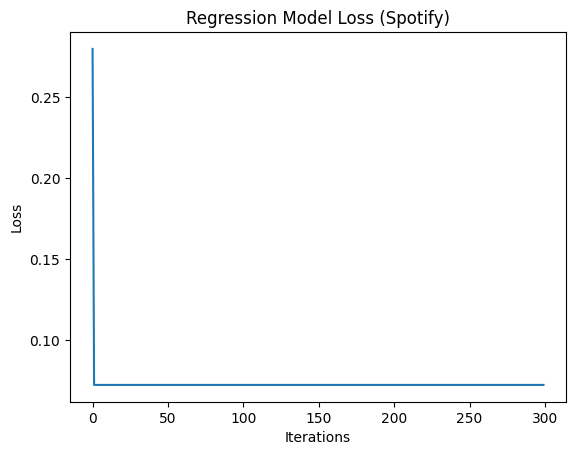

In [41]:
I = x_train_reg.shape[0]
O = y_train_reg.shape[0]
H1, H2, H3 = 64, 32, 16

np.random.seed(seed)
init_params_reg = Initialization(I, H1, H2, H3, O)

# 300 iterations is just for testing. For a good result, try 3000-5000.
losses_reg, params_reg = training_reg(x_train_reg, y_train_reg, init_params_reg, eta=0.05, num_iters=300, lmbda=0.01)
plt.plot(losses_reg)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.title('Regression Model Loss (Spotify)')
plt.show()

In [38]:
#Sample test case
y_pred_test_reg, _ = feed_forward(x_test_reg, params_reg)
test_loss = loss_compute(y_pred_test_reg, y_test_reg)
print(f"Final Test MSE (Spotify): {test_loss}")

assert losses_reg[-1] < losses_reg[0], "Loss should decrease!"
print('Sample Test passed', '\U0001F44D')

Final Test MSE (Spotify): 0.07102127185232658
Sample Test passed 👍
